In [1]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from keras.applications.vgg16 import VGG16
from keras.models import Sequential, Model
from keras.layers import Dense, GlobalAveragePooling2D, Input
from keras.optimizers import SGD, adadelta
from keras.utils import np_utils, plot_model
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
import numpy as np
import os
import keras.backend.tensorflow_backend as KTF
import tensorflow as tf

Using TensorFlow backend.


In [2]:
# 各種データ
x = []
y = []
dictlabel = {} # ラベル格納
width = 128 # 立幅
side = 128 # 横幅
test_size = 0.3 # 訓練データの割合
datadir = "dataset/" # データ格納先
traindir = datadir + "train/" #訓練データ格納先
testdir = datadir + "test/" #テストデータ格納先
batch_size = 32 # 学習毎のデータ数
epoch = 400 # 学習回数

In [3]:
old_session = KTF.get_session()
session = tf.Session('')
KTF.set_session(session)
KTF.set_learning_phase(1)

In [4]:
# steps_per_epoch 算出するために、訓練テストディレクトリそれぞれのファイル数（画像データ数）を算出する
traindatacount = 0
testdatacount = 0
labelcount = 0
for labeldir in os.listdir(traindir):
    labelcount = labelcount + 1
    for f in os.listdir(traindir + labeldir):
        traindatacount = traindatacount + 1
for labeldir in os.listdir(testdir):
    for f in os.listdir(testdir + labeldir):
        testdatacount = testdatacount + 1

In [5]:
# モデル構築
# 転移学習
input_tensor = Input(shape=(width, side, 3))
base_model = VGG16(weights='imagenet', include_top=False,input_tensor=input_tensor)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(labelcount, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)
for layer in base_model.layers[:15]:
    layer.trainable = False

In [6]:
# モデルコンパイル
model.compile(loss="categorical_crossentropy", optimizer='adadelta', metrics=["accuracy"])

In [7]:
# モデルを表示
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0         
__________

In [8]:
# データ読み込み
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [9]:
train_generator = train_datagen.flow_from_directory(
        'dataset/train',
        target_size=(width, side),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        'dataset/test',
        target_size=(width, side),
        batch_size=batch_size,
        class_mode='categorical')

Found 70473 images belonging to 101 classes.
Found 30527 images belonging to 101 classes.


In [10]:
# 1回あたりの画像数を計算する
steps_per_epoch = traindatacount // batch_size
validation_steps = testdatacount // batch_size

In [11]:
print(steps_per_epoch)
print(validation_steps)

2202
953


In [12]:
open("model_convertcolor", "w").write(model.to_json())

11595

In [304]:
### add for TensorBoard
log_filepath = "./logs/"
# tb_cb = TensorBoard(log_dir=log_filepath, histogram_freq=1, write_graph=True, write_images=True)
###
check = ModelCheckpoint("model_convertcolor.hdf5", save_best_only="true")
earlystop = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='auto')
callbacks = [check, earlystop]

In [305]:
# 学習
history = model.fit_generator(generator=train_generator,
                                steps_per_epoch=steps_per_epoch,
                                epochs=epoch,
                                verbose=1,
                                validation_data=validation_generator,
                                validation_steps=validation_steps,
                                callbacks = callbacks,
                                shuffle=True)

Epoch 1/400
2202/2202 [==============================] - 442s 201ms/step - loss: 3.2656 - acc: 0.2305 - val_loss: 2.6064 - val_acc: 0.3644
Epoch 2/400
2202/2202 [==============================] - 435s 197ms/step - loss: 2.2844 - acc: 0.4292 - val_loss: 2.2964 - val_acc: 0.4327
Epoch 3/400
2202/2202 [==============================] - 399s 181ms/step - loss: 1.8207 - acc: 0.5291 - val_loss: 2.2066 - val_acc: 0.4646
Epoch 4/400
2202/2202 [==============================] - 397s 180ms/step - loss: 1.4234 - acc: 0.6192 - val_loss: 2.1372 - val_acc: 0.4853
Epoch 5/400
2202/2202 [==============================] - 398s 181ms/step - loss: 1.0438 - acc: 0.7111 - val_loss: 2.2556 - val_acc: 0.4877
Epoch 6/400
2202/2202 [==============================] - 392s 178ms/step - loss: 0.6966 - acc: 0.8005 - val_loss: 2.4919 - val_acc: 0.4909
Epoch 7/400
2202/2202 [==============================] - 394s 179ms/step - loss: 0.4254 - acc: 0.8735 - val_loss: 2.9516 - val_acc: 0.4832
Epoch 8/400
2202/2202 [====

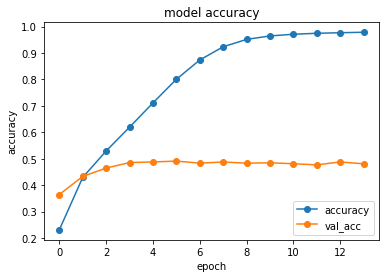

In [306]:
import matplotlib.pyplot as plt
# 精度の履歴をプロット
plt.plot(history.history['acc'],"o-", label="accuracy")
plt.plot(history.history['val_acc'],"o-", label="val_acc")
plt.title('model accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(loc="lower right")
plt.show()

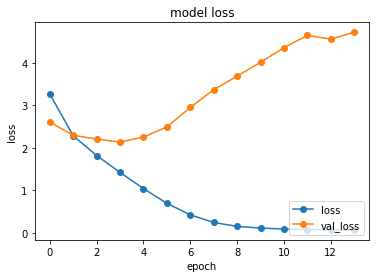

In [307]:
# 損失の履歴をプロット
plt.plot(history.history['loss'],"o-", label="loss",)
plt.plot(history.history['val_loss'],"o-", label="val_loss")
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc='lower right')
plt.show()